In [1]:
import numpy as np
import pdb
import matplotlib.pyplot as plt

In [53]:
def discrete_exp_mix(x, K=2, plot_it=True, verbose=True):
    # Function to fit a mixture of discrete exponential distributions to inter-event intervals
    
    if np.min(x) != 0:
        x = x - 1
        subtracted = True
    else:
        subtracted = False
    
    epsilon = 1e-6
    max_iter = 1e4
    
    # Initialize parameters
    betas = np.full((K,), np.nan)
    weights = np.full((K,), np.nan)
    t_hat = np.full((K * 2,), np.nan)
    
    # Find starting values by splitting up the data
    bins = np.linspace(np.min(x), np.max(x), K + 1)
    for k in range(K):
        betas[k] = np.nanmean(x[(x >= bins[k]) & (x <= bins[k + 1])])
        weights[k] = 1 / K  # start by assuming an equal mixture
    
    # Fill into the parameter vector
    t_hat[0::2] = betas
    t_hat[1::2] = weights
    
    # Define geometric pdf
    def geo_f(x, beta):
        return (1 / (1 + beta)) * ((beta / (1 + beta)) ** x)
    
    # Define weighted distributions formula
    def w_f(x, theta):
        return theta[1] * geo_f(x, theta[0])
    
    def z_labels(x, theta):
        # Generate the Z labels for this iteration
        K = len(theta) // 2
        Z = np.full((K, len(x)), np.nan)
        idx = np.array([0, 1])

        for k in range(K):
            Z[k, :] = w_f(x, theta[idx])
            idx = idx + 2
        
        pdf = np.copy(Z)
        G = np.sum(Z, axis=0)
        G = G + 5e-324 # avoid divide by 0's
        Z = Z / G

        return Z, pdf
    
    if K != 1:
        print('Starting EM')
        exit_flag = True  # switches to false if we exit for a bad reason
        i = 0
        stop = False
        while not stop:
            # E-step: calculate the expectation of our observations | params
            Z, pdf = z_labels(x, t_hat)
            
            # M-step: update the parameters
            betas = t_hat[0::2]
            weights = t_hat[1::2]
            betas_n = np.full_like(betas, np.nan)
            weights_n = np.full_like(weights, np.nan)
            
            # Update the betas
            for k in range(K):
                betas_n[k] = np.sum(Z[k, :] * x) / np.sum(Z[k, :])
            
            # Update the weights
            weights_n = np.mean(Z, axis=1)
            
            # CHECK HERE that with weights
            #pdb.set_trace()
            
            # Update theta estimates for the next round
            last_t_hat = np.copy(t_hat)
            t_hat[0::2] = betas_n
            t_hat[1::2] = weights_n
            
            # Stop if we've reached our stopping criteria
            stop = np.all(np.logical_and(1 - epsilon <= t_hat / last_t_hat, t_hat / last_t_hat <= 1 + epsilon))
            stop = stop or i > max_iter
            
            if np.sum(np.isnan(t_hat)) > 0:
                stop = True
                exit_flag = False
            
            if verbose and round(i / 100) * 100 == i:
                lik = np.sum(np.log(np.sum(pdf, axis=0)))
                print(f'\n Iter: {i}, Likelihood: {lik:.4f}')
            
            i += 1
    else:
        # If K == 1, ML estimate is the mean of observations
        t_hat[0] = np.mean(x)
        t_hat[1] = 1
        exit_flag = True
        i = 0
    
    if exit_flag:
        print(f'\n EM finished after {i} iterations')
        
        theta = t_hat
        
        # Get max likelihood mixture
        Z, pdf = z_labels(x, theta)
        Z_labels = np.argmax(Z, axis=0)
        
        # Likelihood
        lik = np.sum(np.log(np.sum(pdf, axis=0)))
        
        if plot_it:
            import matplotlib.pyplot as plt
            
            counts, edges = np.histogram(x, bins=np.arange(np.max(x) + 2) - 0.5, density=True)
            plt.semilogy(edges[:-1], counts, '.k', markersize=20)
            
            _, pdf_plot = z_labels(np.arange(np.max(x) + 1), theta)
            plt.plot(np.arange(np.max(x) + 1) + 0.5, np.sum(pdf_plot, axis=0), linewidth=2)
            
            plt.show()
        
        # If we subtracted 1 to make the data start at 0 to fit the model,
        # we need to correct the survival parameter for interpretability
        if subtracted:
            theta[0::2] = theta[0::2] + 1
        
        return theta, Z_labels, lik
    else:
        print('\n EM failed to converge!')
        return None
    
# Example usage:
# theta, Z_labels, lik = discrete_exp_mix(x, K=2)


# Simulate Data

In [111]:
beta_1 = 1.6
beta_2 = 17.2
weight_1 = 0.3
weight_2 = 1- weight_1
theta = np.array([beta_1, weight_1, beta_2, weight_2])
x = np.arange(1,26)

# Define geometric pdf
def geo_f(x, beta):
    return (1 / (1 + beta)) * ((beta / (1 + beta)) ** x)

# Define weighted distributions formula
def w_f(x, theta):
    return theta[1] * geo_f(x, theta[0])

def z_labels(x, theta):
    # Generate the Z labels for this iteration
    K = len(theta) // 2
    Z = np.full((K, len(x)), np.nan)
    idx = np.array([0, 1])

    for k in range(K):
        #pdb.set_trace()
        Z[k, :] = w_f(x, theta[idx])
        idx = idx + 2

    pdf = np.copy(Z)
    G = np.sum(Z, axis=0)
    G = G + 5e-324 # avoid divide by 0's
    Z = Z / G

    return Z, pdf


Starting EM

 Iter: 0, Likelihood: -6687.4775

 Iter: 100, Likelihood: -5256.4332

 Iter: 200, Likelihood: -5256.4325

 Iter: 300, Likelihood: -5256.4318

 Iter: 400, Likelihood: -5256.4310

 Iter: 500, Likelihood: -5256.4303

 Iter: 600, Likelihood: -5256.4297

 Iter: 700, Likelihood: -5256.4290

 Iter: 800, Likelihood: -5256.4283

 Iter: 900, Likelihood: -5256.4277

 Iter: 1000, Likelihood: -5256.4271

 Iter: 1100, Likelihood: -5256.4264

 Iter: 1200, Likelihood: -5256.4258

 Iter: 1300, Likelihood: -5256.4252

 Iter: 1400, Likelihood: -5256.4246

 Iter: 1500, Likelihood: -5256.4241

 Iter: 1600, Likelihood: -5256.4235

 Iter: 1700, Likelihood: -5256.4229

 Iter: 1800, Likelihood: -5256.4224

 Iter: 1900, Likelihood: -5256.4218

 Iter: 2000, Likelihood: -5256.4213

 Iter: 2100, Likelihood: -5256.4208

 Iter: 2200, Likelihood: -5256.4203

 Iter: 2300, Likelihood: -5256.4198

 Iter: 2400, Likelihood: -5256.4193

 Iter: 2500, Likelihood: -5256.4188

 Iter: 2600, Likelihood: -5256.4183




 Iter: 21900, Likelihood: -5256.3889

 Iter: 22000, Likelihood: -5256.3889

 Iter: 22100, Likelihood: -5256.3889

 Iter: 22200, Likelihood: -5256.3888

 Iter: 22300, Likelihood: -5256.3888

 Iter: 22400, Likelihood: -5256.3888

 Iter: 22500, Likelihood: -5256.3888

 Iter: 22600, Likelihood: -5256.3887

 Iter: 22700, Likelihood: -5256.3887

 Iter: 22800, Likelihood: -5256.3887

 Iter: 22900, Likelihood: -5256.3887

 Iter: 23000, Likelihood: -5256.3886

 Iter: 23100, Likelihood: -5256.3886

 Iter: 23200, Likelihood: -5256.3886

 Iter: 23300, Likelihood: -5256.3886

 Iter: 23400, Likelihood: -5256.3885

 Iter: 23500, Likelihood: -5256.3885

 Iter: 23600, Likelihood: -5256.3885

 Iter: 23700, Likelihood: -5256.3885

 Iter: 23800, Likelihood: -5256.3884

 Iter: 23900, Likelihood: -5256.3884

 Iter: 24000, Likelihood: -5256.3884

 Iter: 24100, Likelihood: -5256.3884

 Iter: 24200, Likelihood: -5256.3884

 Iter: 24300, Likelihood: -5256.3883

 Iter: 24400, Likelihood: -5256.3883

 Iter: 2450


 Iter: 43500, Likelihood: -5256.3869

 Iter: 43600, Likelihood: -5256.3869

 Iter: 43700, Likelihood: -5256.3869

 Iter: 43800, Likelihood: -5256.3869

 Iter: 43900, Likelihood: -5256.3869

 Iter: 44000, Likelihood: -5256.3869

 Iter: 44100, Likelihood: -5256.3869

 Iter: 44200, Likelihood: -5256.3869

 Iter: 44300, Likelihood: -5256.3869

 Iter: 44400, Likelihood: -5256.3869

 Iter: 44500, Likelihood: -5256.3869

 Iter: 44600, Likelihood: -5256.3869

 Iter: 44700, Likelihood: -5256.3869

 Iter: 44800, Likelihood: -5256.3869

 Iter: 44900, Likelihood: -5256.3869

 Iter: 45000, Likelihood: -5256.3869

 Iter: 45100, Likelihood: -5256.3869

 Iter: 45200, Likelihood: -5256.3869

 Iter: 45300, Likelihood: -5256.3869

 Iter: 45400, Likelihood: -5256.3869

 Iter: 45500, Likelihood: -5256.3869

 Iter: 45600, Likelihood: -5256.3869

 Iter: 45700, Likelihood: -5256.3869

 Iter: 45800, Likelihood: -5256.3869

 Iter: 45900, Likelihood: -5256.3869

 Iter: 46000, Likelihood: -5256.3869

 Iter: 4610

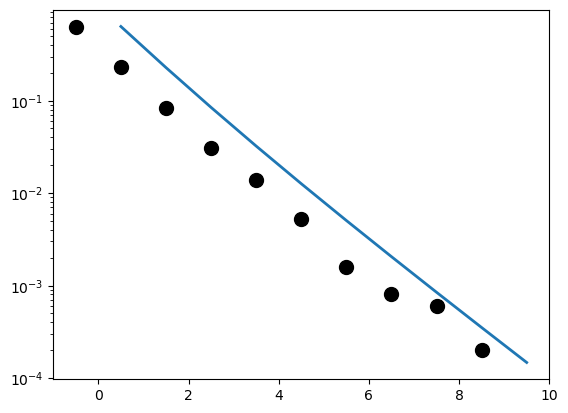

In [54]:
# Test the function on the simulated data
estimated_theta, estimated_labels, likelihood = discrete_exp_mix(simulated_data, K=2)



In [ ]:
last_t_hat = np.copy(t_hat)
t_hat[0::2] = betas_n
t_hat[1::2] = weights_n

In [84]:
pdf = np.copy(Z) # [2,5000]
G = np.sum(Z, axis=0) [5000,]
Z = Z / G # Elementwise division


In [55]:
estimated_theta

array([0.42169151, 0.46370019, 0.74111823, 0.53629981])

5e-324